# Lab 2: Deep Learning
## Universidad Santiago de Compostela

Students:
- Víctor Barreiro Domínguez
- Maximiliano Hormazábal Lagos


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow.keras

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# utils 
def vectorize_sequences(sequences, dimension = 10000):
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        # Sets specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results

def visualize_fit(model,history):
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    results = model.evaluate(x_test, y_test)
    print(results)

## 1. Develop a neural network for the IMDB dataset.
### Load dataset

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000) 

In [4]:
# word_index is a dictionary mapping words to integer index
word_index = imdb.get_word_index()

# Reverses it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decodes de review. Note that the indices are offset by 3 because 0, 1, and 2 are reserved 
# indices por "padding", "start of sequence" and "unknown"
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [5]:
import numpy as np
# Vectorized training data
x_train = vectorize_sequences(train_data)

# Vectorized test data
x_test = vectorize_sequences(test_data)

print(x_train[0])

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_val = x_train[:10000] # Copy of x_train from the begining (0) to 9999
partial_x_train = x_train[10000:] # Copy of x_train from 10000 to the end

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

[0. 1. 1. ... 0. 0. 0.]


### Base Model

In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers

# we are using the name parameter to identify better model and layers
model = models.Sequential(name='imdb')

# using the input_shappe parameter Keras will create an input layer to insert before the current layer. 
model.add(layers.Dense(16, name='hidden_1', activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, name='hidden_2',activation='relu'))
model.add(layers.Dense(1, name='output',  activation='sigmoid'))

model.summary()

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 16)                160016    
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

## 2. Regularize the model to avoid overfitting using several of these techniques:
### Validation sets and cross-validation

In [8]:
def validation_test(validation_split):
    # === Build the model ===
    model = models.Sequential(name='imdb')
    model.add(layers.Dense(16, name='hidden_1', activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, name='hidden_2',activation='relu'))
    model.add(layers.Dense(1, name='output',  activation='sigmoid'))

    model.summary()

    # === Train the model ===

    # Compile the model
    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    history = model.fit(x_train,
                        y_train,
                        epochs = 20,
                        batch_size = 512,
                        validation_split = validation_split,
                        verbose = 0)

    visualize_fit(model,history)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 16)                160016    
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


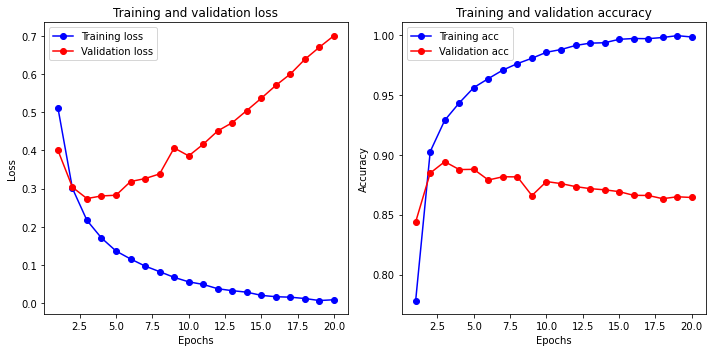

782/782 [==============================] - 4s 5ms/step - loss: 0.7762 - accuracy: 0.8456
[0.7761926054954529, 0.8455600738525391]


In [9]:
validation_test(validation_split=0.4)

In [10]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Dropout

In [11]:
def dropout_test(dropouts):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dropout(dropouts[0]))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(dropouts[1]))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 20,
                        batch_size = 512,
                        verbose = 0,
                        validation_data = (x_val, y_val))

    visualize_fit(model,history)
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


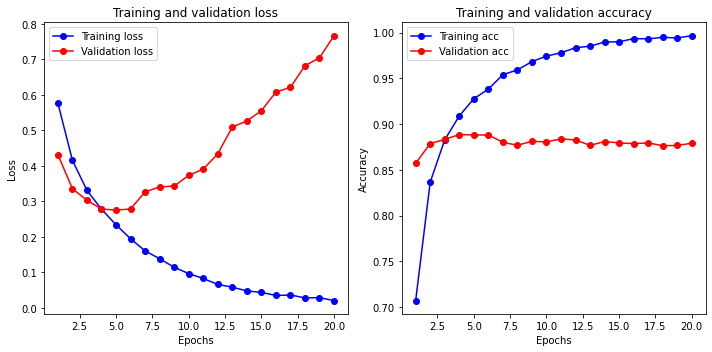

782/782 [==============================] - 4s 5ms/step - loss: 0.8231 - accuracy: 0.8668
[0.8230875730514526, 0.8667600750923157]


In [12]:
dropout_test(dropouts=[0.2,0.5])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16)                160016    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_39 (Dense)            (None, 16)                272       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_40 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


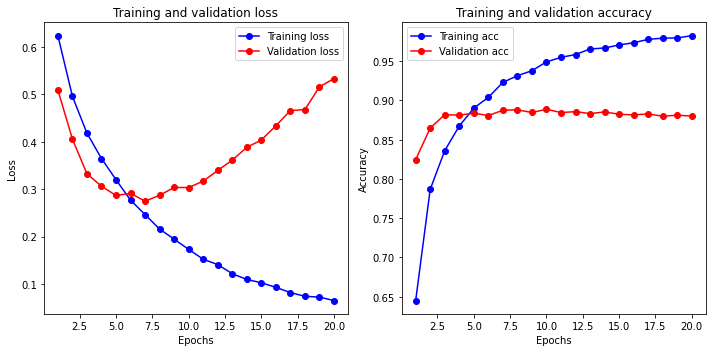

782/782 [==============================] - 4s 5ms/step - loss: 0.5731 - accuracy: 0.8705
[0.5730902552604675, 0.8704800605773926]


In [38]:
dropout_test(dropouts=[0.5,0.5])

## Batch normalization

In [13]:
def batch_norm_test(center=True,scale=True):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.BatchNormalization(center=center,scale=scale))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization(center=center,scale=scale))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 20,
                        batch_size = 512,
                        verbose=0,
                        validation_data = (x_val, y_val))
    visualize_fit(model,history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,433
Trainable params: 160,369
Non-tr

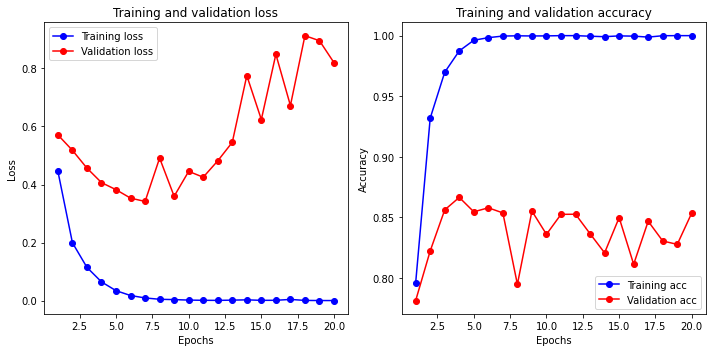

782/782 [==============================] - 5s 6ms/step - loss: 0.8871 - accuracy: 0.8423
[0.8871280550956726, 0.8423200845718384]


In [14]:
batch_norm_test(center=True,scale=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                160016    
                                                                 
 batch_normalization_2 (Batc  (None, 16)               48        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_3 (Batc  (None, 16)               48        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,401
Trainable params: 160,337
Non-tr

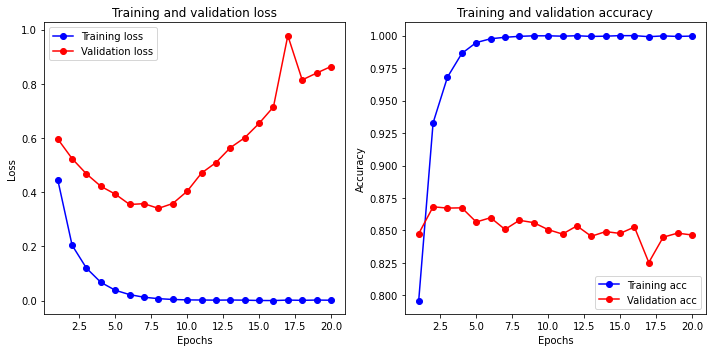

782/782 [==============================] - 5s 6ms/step - loss: 0.9162 - accuracy: 0.8384
[0.9161710739135742, 0.8384400606155396]


In [15]:
batch_norm_test(center=False,scale=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                160016    
                                                                 
 batch_normalization_4 (Batc  (None, 16)               48        
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 batch_normalization_5 (Batc  (None, 16)               48        
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,401
Trainable params: 160,337
Non-tr

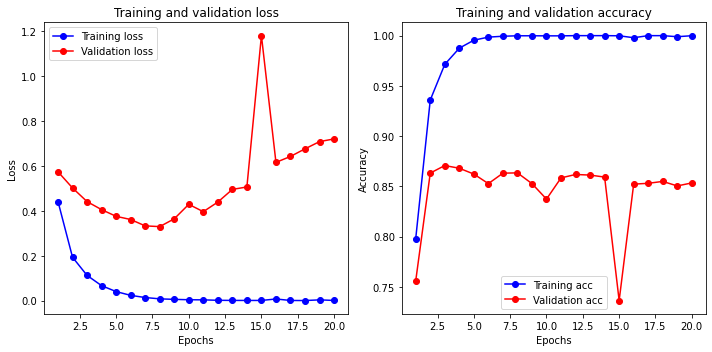

782/782 [==============================] - 4s 5ms/step - loss: 0.7867 - accuracy: 0.8399
[0.7866905927658081, 0.8399200439453125]


In [16]:
batch_norm_test(center=True,scale=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                160016    
                                                                 
 batch_normalization_6 (Batc  (None, 16)               32        
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 batch_normalization_7 (Batc  (None, 16)               32        
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,369
Trainable params: 160,305
Non-tr

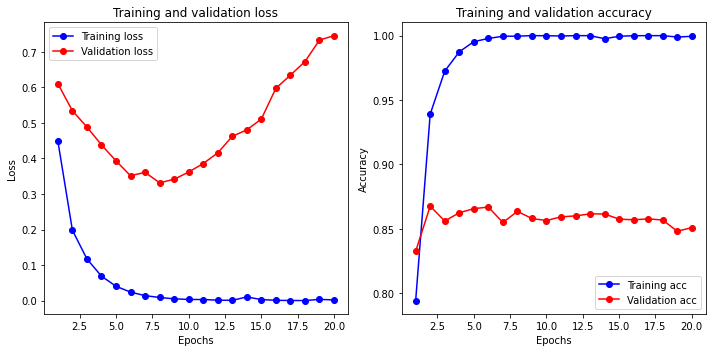

782/782 [==============================] - 5s 6ms/step - loss: 0.7963 - accuracy: 0.8368
[0.7963410019874573, 0.8367600440979004]


In [17]:
batch_norm_test(center=False,scale=False)

## Weight Regularization

In [18]:
from tensorflow.keras import regularizers

In [19]:
def weight_testing(regularizer):
    model = models.Sequential(name='imdb')
    
    model.add(layers.Dense(16, kernel_regularizer=regularizer, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, kernel_regularizer=regularizer, activation='relu'))
    model.add(layers.Dense(1, name='output',  activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    model.summary()

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 20,
                        batch_size = 512,
                        verbose = 0,
                        validation_data = (x_val, y_val))
    visualize_fit(model,history)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                160016    
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


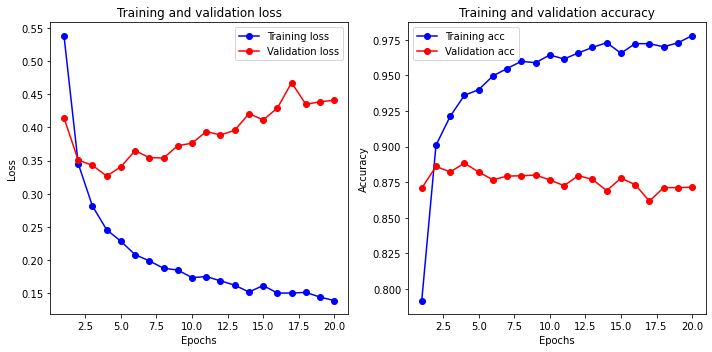

782/782 [==============================] - 5s 6ms/step - loss: 0.4677 - accuracy: 0.8623
[0.4677172601222992, 0.8622800707817078]


In [20]:
regularizer = regularizers.l2(0.001)
weight_testing(regularizer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                160016    
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


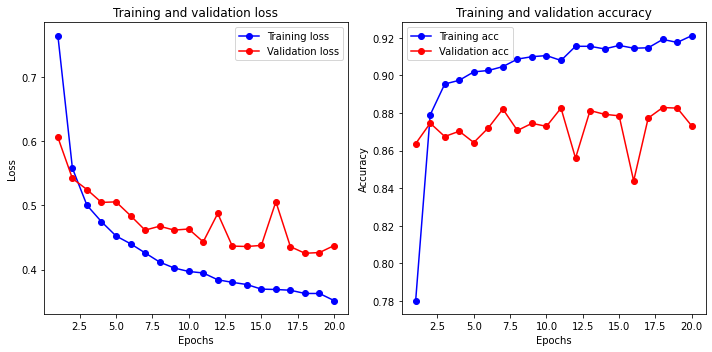

782/782 [==============================] - 4s 5ms/step - loss: 0.4476 - accuracy: 0.8698
[0.44763311743736267, 0.8698400855064392]


In [21]:
regularizer = regularizers.l2(0.01)
weight_testing(regularizer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 16)                160016    
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


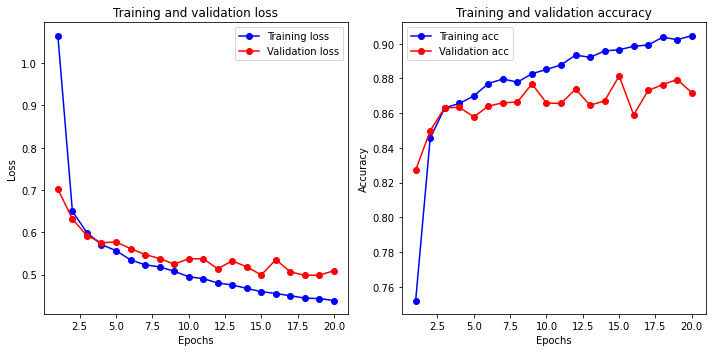

782/782 [==============================] - 4s 6ms/step - loss: 0.5120 - accuracy: 0.8676
[0.5119926333427429, 0.8676400780677795]


In [22]:
regularizer = regularizers.l1(0.001)
weight_testing(regularizer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                160016    
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


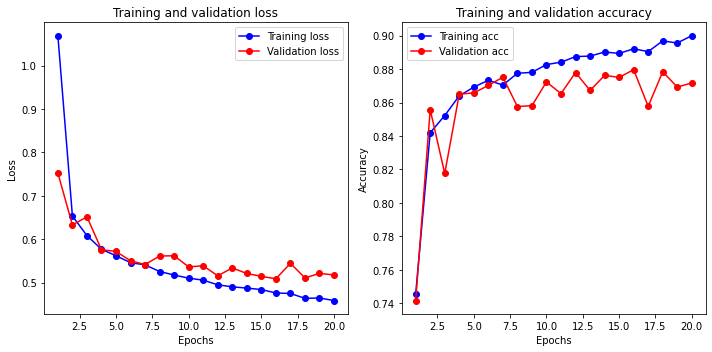

782/782 [==============================] - 4s 6ms/step - loss: 0.5216 - accuracy: 0.8669
[0.5216367244720459, 0.8668800592422485]


In [23]:
regularizers.l1_l2(l1=0.001, l2=0.001)
weight_testing(regularizer)

### Early Stopping

In [24]:
from keras.callbacks import EarlyStopping

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=3)

In [26]:
def early_sopping_test(early_stopping):
    model = models.Sequential(name='imdb')
    model.add(layers.Dense(16, name='hidden_1', activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, name='hidden_2',activation='relu'))
    model.add(layers.Dense(1, name='output',  activation='sigmoid'))

    model.summary()

    # Compile the model
    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 20,
                        batch_size = 512,
                        verbose = 0,
                        validation_data = (x_val, y_val),
                        callbacks=[early_stopping])
    visualize_fit(model,history)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 16)                160016    
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


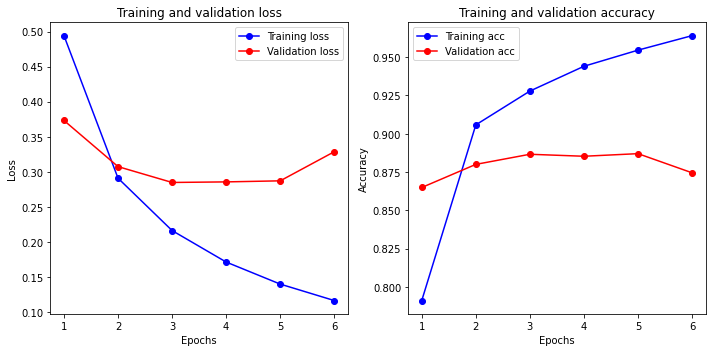

782/782 [==============================] - 4s 5ms/step - loss: 0.3630 - accuracy: 0.8607
[0.36304861307144165, 0.8606800436973572]


In [27]:
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=3)
early_sopping_test(early_stopping)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 16)                160016    
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


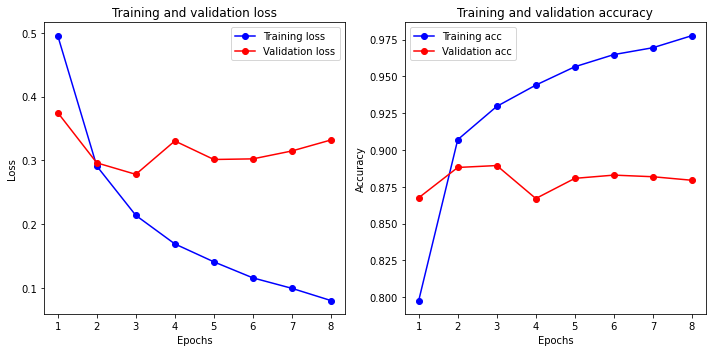

782/782 [==============================] - 5s 6ms/step - loss: 0.3651 - accuracy: 0.8684
[0.36512741446495056, 0.8684000372886658]


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=5)
early_sopping_test(early_stopping)

### Kernel Initializer

In [29]:
def initializer_testing(initializer):
    model = models.Sequential(name='imdb')
    
    model.add(layers.Dense(16, kernel_initializer=initializer, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, kernel_initializer=initializer, activation='relu'))
    model.add(layers.Dense(1, name='output',  activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    model.summary()

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 20,
                        batch_size = 512,
                        verbose = 0,
                        validation_data = (x_val, y_val))
    visualize_fit(model,history)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 16)                160016    
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


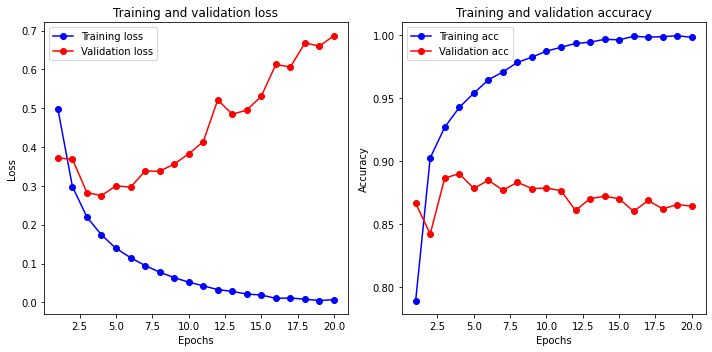

782/782 [==============================] - 5s 6ms/step - loss: 0.7559 - accuracy: 0.8495
[0.7558660507202148, 0.8495200276374817]


In [30]:
initializer = tf.keras.initializers.HeNormal()
initializer_testing(initializer=initializer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                160016    
                                                                 
 dense_26 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


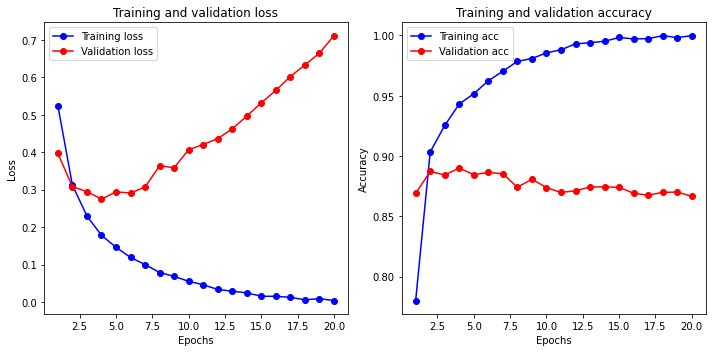

782/782 [==============================] - 4s 6ms/step - loss: 0.7602 - accuracy: 0.8520
[0.7601581811904907, 0.8520400524139404]


In [31]:
initializer = tf.keras.initializers.glorot_normal()
initializer_testing(initializer=initializer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                160016    
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


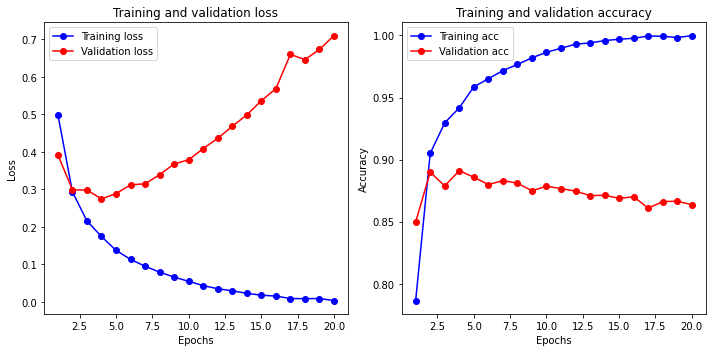

782/782 [==============================] - 4s 5ms/step - loss: 0.7916 - accuracy: 0.8480
[0.7916035056114197, 0.8480000495910645]


In [32]:
initializer = tf.keras.initializers.variance_scaling()
initializer_testing(initializer=initializer)

### Optimizer

In [33]:
def optimizer_testing(optimizer):
    model = models.Sequential(name='imdb')
    
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, name='output',  activation='sigmoid'))

    model.compile(optimizer = optimizer,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    model.summary()

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 20,
                        batch_size = 512,
                        verbose = 0,
                        validation_data = (x_val, y_val))
    visualize_fit(model,history)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 16)                160016    
                                                                 
 dense_30 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


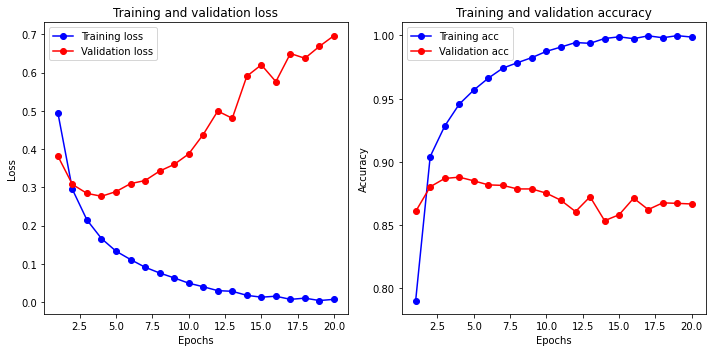

782/782 [==============================] - 4s 5ms/step - loss: 0.7731 - accuracy: 0.8514
[0.7731235027313232, 0.8514400720596313]


In [34]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

optimizer_testing(optimizer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 16)                160016    
                                                                 
 dense_32 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


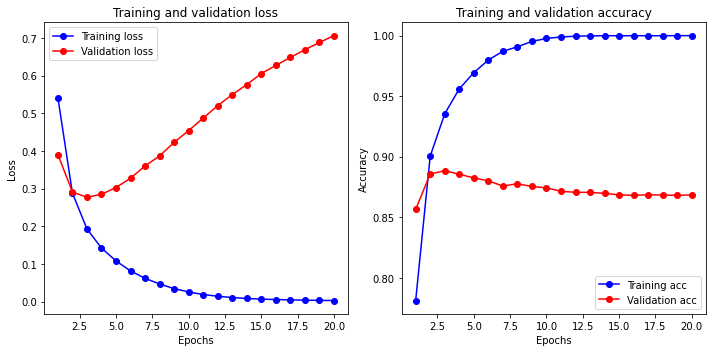

782/782 [==============================] - 5s 6ms/step - loss: 0.7659 - accuracy: 0.8553
[0.7659491896629333, 0.8553200364112854]


In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

optimizer_testing(optimizer)

Model: "imdb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 16)                160016    
                                                                 
 dense_34 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


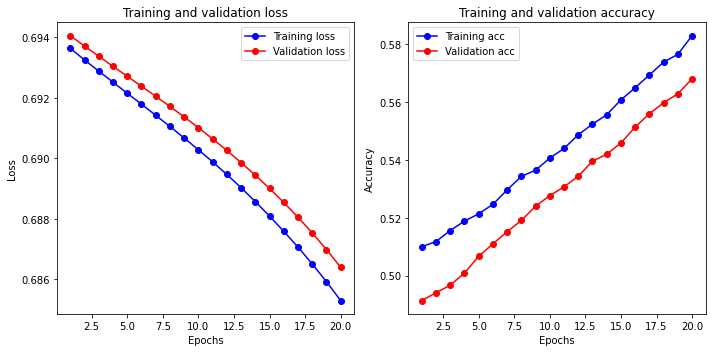

782/782 [==============================] - 5s 6ms/step - loss: 0.6860 - accuracy: 0.5747
[0.6860038638114929, 0.5746800303459167]


In [36]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

optimizer_testing(optimizer)

### Combining regularizations

- L1 regularization (Lasso regularization)
- L2 regularization (Ridge regularization)
- Dropout
- Early stopping

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                160016    
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


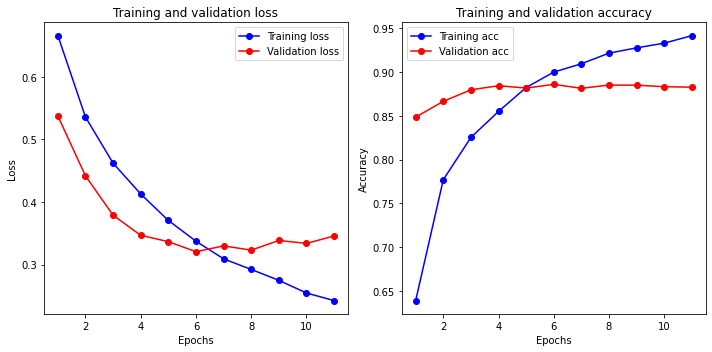

782/782 [==============================] - 5s 6ms/step - loss: 0.3578 - accuracy: 0.8798
[0.3577667772769928, 0.8798000812530518]


In [39]:
dropouts = [0.5,0.5]
regularizer_l1_l2 = regularizers.l2(0.001)
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=5)

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizer_l1_l2, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(dropouts[0]))
model.add(layers.Dense(16, kernel_regularizer=regularizer_l1_l2, activation='relu'))
model.add(layers.Dropout(dropouts[1]))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer = 'rmsprop',
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    verbose = 0,
                    validation_data = (x_val, y_val),
                    callbacks=[early_stopping])

visualize_fit(model,history)